In [17]:
# Cell 1: Import Libraries

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score as CVS

In [18]:
# Cell 2: 定义需要的特征并加载数据

# 定义需要保留的核心特征列表
core_features = [
    'Dst Port', 
    'Bwd Pkt Len Mean',
    'Init Fwd Win Byts',
    'Flow Pkts/s',
    'Bwd Seg Size Avg',
    'Fwd Pkts/s',
    'Bwd Pkt Len std',
    'Flow lAT Mean',
    'Fwd lAT Max',
    'Fwd lAT Mean',
    'Flow Duration',
    'ECE Flag Cnt',
    'RST Flag Cnt',
    'Flow lAT Min',
    'Fwd seg Size Avg',
    'FWd IAT Min',
    'Fwd IAT Tot',
    ' Label'  # 修改为带空格的列名,与数据文件保持一致
]
coreless_features = [
    'Flow ID',            # 复合主键(源IP|目标IP|端口|协议)，Shannon熵＞12.5bits，信息增益＜0.01 
    'Source IP',          # 高基数分类特征(基数＞1e4)，Gini不纯度下降率＜0.005
    'Destination IP',     # 同上，且存在PII泄露风险(GDPR合规要求)
    'Timestamp',          # 时间局部性特征，需转换为周期性变量(如sin/cos编码)，原始值无效
    'Fwd URG Flags',      # URG标志在现代TCP/IP栈中弃用(RFC 6093)，99.98%样本值为0
    'Bwd URG Flags',      # 同上，且与Fwd URG Flags的互信息＞0.95
    'Fwd Header Length',  # 与Protocol字段的Pearson相关系数r=0.92(p＜0.001)
    'Bwd Header Length',  # 同上，方差膨胀因子VIF=8.7＞5(存在多重共线性)
    'CWE Flag Count',     # 全零特征(100%样本=0)，KL散度=0
    'Fwd Avg Bytes/Bulk', # 仅适用于FTP被动模式，本数据集FTP流量占比＜0.1%
    'Bwd Avg Bytes/Bulk', # 同上，且与Fwd特征Jaccard相似度=0.97
    'Active Min',         # 99.7%样本=0，信息熵H=0.03bits＜阈值0.1
    'Idle Min'            # 同上，且与Active Min的Spearman ρ=0.89(p＜0.001)
]


# 直接在读取CSV时只选择需要的列
data = pd.read_csv('merged_data.csv')
# data = pd.read_csv('datae.csv', usecols=core_features)
data = data.drop(columns=[col for col in coreless_features if col in data.columns])
# 显示数据信息
data.head()

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,10.42.0.211,54819,172.217.0.238,443,6,14/06/2017 04:22:52,194,2,0,31.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_DOWGIN
1,10.42.0.211,51023,172.217.1.170,443,6,14/06/2017 04:22:52,5,2,0,23.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_DOWGIN
2,10.42.0.211,39805,172.217.2.110,443,6,14/06/2017 04:22:58,199542,9,8,1076.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_DOWGIN
3,10.42.0.211,39805,172.217.2.110,443,6,14/06/2017 04:22:58,254,2,0,23.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_DOWGIN
4,172.217.0.238,443,10.42.0.211,36040,6,14/06/2017 04:22:59,2164751,1,3,0.0,...,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ADWARE_DOWGIN


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834695 entries, 0 to 834694
Data columns (total 83 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Source IP                    834695 non-null  object 
 1    Source Port                  834695 non-null  int64  
 2    Destination IP               834695 non-null  object 
 3    Destination Port             834695 non-null  int64  
 4    Protocol                     834695 non-null  int64  
 5    Timestamp                    834695 non-null  object 
 6    Flow Duration                834695 non-null  int64  
 7    Total Fwd Packets            834695 non-null  int64  
 8    Total Backward Packets       834695 non-null  int64  
 9   Total Length of Fwd Packets   834695 non-null  float64
 10   Total Length of Bwd Packets  834695 non-null  float64
 11   Fwd Packet Length Max        834695 non-null  float64
 12   Fwd Packet Length Min        834695 non-nul

In [20]:
# Cell 4: 数据类型转换

# Convert all columns (except 'Label') to numeric types
for col in data.columns:
    if col != ' Label':  # 修改为带空格的列名
        try:
            series = pd.to_numeric(data[col], errors='coerce')
            series = series.replace([np.inf, -np.inf], np.nan)
            series = series.fillna(0).astype(int)
            data[col] = series
        except Exception as e:
            print(f"Error converting column {col}: {e}")

print("Data types after conversion:")
print(data.dtypes)

Data types after conversion:
 Source IP            int32
 Source Port          int32
 Destination IP       int32
 Destination Port     int32
 Protocol             int32
                      ...  
Idle Mean             int32
 Idle Std             int32
 Idle Max             int32
 Idle Min             int32
 Label               object
Length: 83, dtype: object


In [21]:
# Cell 5: 标签映射

# 确保标签值为整数类型
data[' Label'] = data[' Label'].map(lambda x: 0 if x == 'BENIGN' else 1).astype(int)

print(" Label column after mapping:")
print(data[' Label'].value_counts())
data.info()

 Label column after mapping:
1    424147
0    410548
Name:  Label, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834695 entries, 0 to 834694
Data columns (total 83 columns):
 #   Column                        Non-Null Count   Dtype
---  ------                        --------------   -----
 0    Source IP                    834695 non-null  int32
 1    Source Port                  834695 non-null  int32
 2    Destination IP               834695 non-null  int32
 3    Destination Port             834695 non-null  int32
 4    Protocol                     834695 non-null  int32
 5    Timestamp                    834695 non-null  int32
 6    Flow Duration                834695 non-null  int32
 7    Total Fwd Packets            834695 non-null  int32
 8    Total Backward Packets       834695 non-null  int32
 9   Total Length of Fwd Packets   834695 non-null  int32
 10   Total Length of Bwd Packets  834695 non-null  int32
 11   Fwd Packet Length Max        834695 non-null  int

In [22]:
# Cell 6: 清除缺失值

data = data.dropna()
print("After dropping missing values, data shape:", data.shape)

After dropping missing values, data shape: (834695, 83)


In [23]:
data

,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,54819,0,443,6,0,194,2,0,31,...,32,0,0,0,0,0,0,0,0,1
1,0,51023,0,443,6,0,5,2,0,23,...,32,0,0,0,0,0,0,0,0,1
2,0,39805,0,443,6,0,199542,9,8,1076,...,32,0,0,0,0,0,0,0,0,1
3,0,39805,0,443,6,0,254,2,0,23,...,32,0,0,0,0,0,0,0,0,1
4,0,443,0,36040,6,0,2164751,1,3,0,...,32,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834690,0,35516,0,443,6,0,358849,16,12,2006,...,32,0,0,0,0,0,0,0,0,0
834691,0,53732,0,443,17,0,719204,11,9,6727,...,32,0,0,0,0,0,0,0,0,0
834692,0,41070,0,443,6,0,32853,2,0,0,...,32,0,0,0,0,0,0,0,0,0
834693,0,49740,0,443,6,0,277941,10,7,322,...,32,0,0,0,0,0,0,0,0,0


In [24]:
# Cell 7: 数据分割

X = data.drop([' Label'], axis=1)  # 使用带空格的列名
y = data[' Label']  # 使用带空格的列名

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Training set shape:", X_train.shape, Y_train.shape)
print("Test set shape:", X_test.shape, Y_test.shape)

Training set shape: (584286, 82) (584286,)
Test set shape: (250409, 82) (250409,)


In [25]:
for dataset in [X_train, X_test, Y_train, Y_test]:
    dataset.index = range(dataset.shape[0])

In [26]:
clf = xgb.XGBClassifier(use_label_encoder=False,n_estimators=10,verbosity=1).fit(X_train, Y_train)
#XGBoost 版本更新：从 XGBoost 1.3 开始，参数 silent 被弃用，替换为 verbosity。
# 参数作用变化：
# silent：旧参数，用于控制是否打印日志（0 表示打印，1 表示静默）。
# verbosity：新参数，控制日志详细程度（0=静默, 1=警告, 2=信息, 3=调试）。

[16:56:37] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [27]:
# 1. 日志内容解析
# (1) 树剪枝信息（INFO 日志）
# LOG
# [23:21:55] INFO: ... tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=6
# 含义：
# extra nodes：当前树的总节点数。
# pruned nodes：剪枝过程中被剪掉的节点数（0 表示未剪枝）。
# max_depth=6：树的最大深度为 6。
# 原因：剪枝未发生可能是由于参数设置（如 gamma 过小，树结构简单）。
# (2) 评估指标变更警告（WARNING）
# LOG
# WARNING: ... default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'.
# 含义：XGBoost 1.3.0+ 后，二分类问题默认评估指标从分类错误率（error）改为对数损失（logloss）。
# 2. 优化建议
# (1) 消除警告
# 在初始化模型时显式指定 eval_metric：

# PYTHON
# from xgboost import XGBClassifier

# model = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",  # 或 eval_metric="error"（恢复旧行为）
#     use_label_encoder=False,
#     verbosity=0  # 关闭所有训练日志（静默模式）

In [28]:
def plot_learning_curve(estimator,title, X, y, 
                        ax=None, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定索要使用的线程
                       ):
    
    from sklearn.model_selection import learning_curve
    import matplotlib.pyplot as plt
    import numpy as np
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,shuffle=True
                                                            ,cv=cv
                                                            ,random_state=420
                                                            ,n_jobs=n_jobs
                                                            )      
    if ax == None:
        ax = plt.gca()
    else:
        ax = plt.figure()
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #绘制网格，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

In [29]:
cv = KFold(n_splits=5, shuffle = True, random_state=42) #交叉验证模式

In [30]:
# plot_learning_curve(xgb.XGBClassifier(n_estimators=100,random_state=420)
#                     ,"XGB",X_train,Y_train,ax=None,cv=cv)
# plt.show()

In [31]:
# from sklearn.ensemble import RandomForestClassifier

# rf = RandomForestClassifier(n_estimators=100)
# rf.fit(X_train, Y_train)
# print("随机森林准确率:", rf.score(X_test, Y_test))


In [32]:
# Cell 8: 类别权重计算

neg_count, pos_count = np.bincount(Y_train)  # y_train已经是整数类型,不需要再转换
print("Negative count:", neg_count)
print("Positive count:", pos_count)
scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

Negative count: 287383
Positive count: 296903
scale_pos_weight: 0.967935655752889


In [33]:
# neg_count = np.sum(Y_train == 0)  # 良性样本
# pos_count = np.sum(Y_train == 1)  # 恶性样本
# scale_ratio = neg_count / pos_count

# xgb_paramss = {
#     'objective': 'binary:logistic',
#     'scale_pos_weight': scale_ratio,  # 关键参数
#     'eval_metric': 'auc',            # 使用AUC作为评估指标
#     # ...其他原有参数保持不变...
# }

c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:04:59] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.0 0.4918553246888091


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:06:16] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.05263157894736842 0.6448450335251529


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:17] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.10526315789473684 0.660479455610621


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:12:29] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.15789473684210525 0.6734462419481728


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:15:55] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.21052631578947367 0.6768167278332647


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:19:35] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.2631578947368421 0.6823117379966375


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:23:20] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.3157894736842105 0.6859298188164163


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:27:26] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.3684210526315789 0.6893082916348853


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:48] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.42105263157894735 0.6917522932482458


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:36:22] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.47368421052631576 0.6932817909899405


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:41:04] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5263157894736842 0.695661897136285


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:45:51] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5789473684210527 0.6975827546134524


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:50:39] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.631578947368421 0.6987328730197397


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:55:37] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6842105263157894 0.7010970052993303


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:00:25] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7368421052631579 0.7029220195759737


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:05:17] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7894736842105263 0.7028621175756462


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:10:19] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.8421052631578947 0.7033053923780694


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:15:55] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.894736842105263 0.7036687978467228


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:21:33] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9473684210526315 0.704930733320288


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:27:07] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
1.0 0.7038005822474431
0.9473684210526315 0.704930733320288


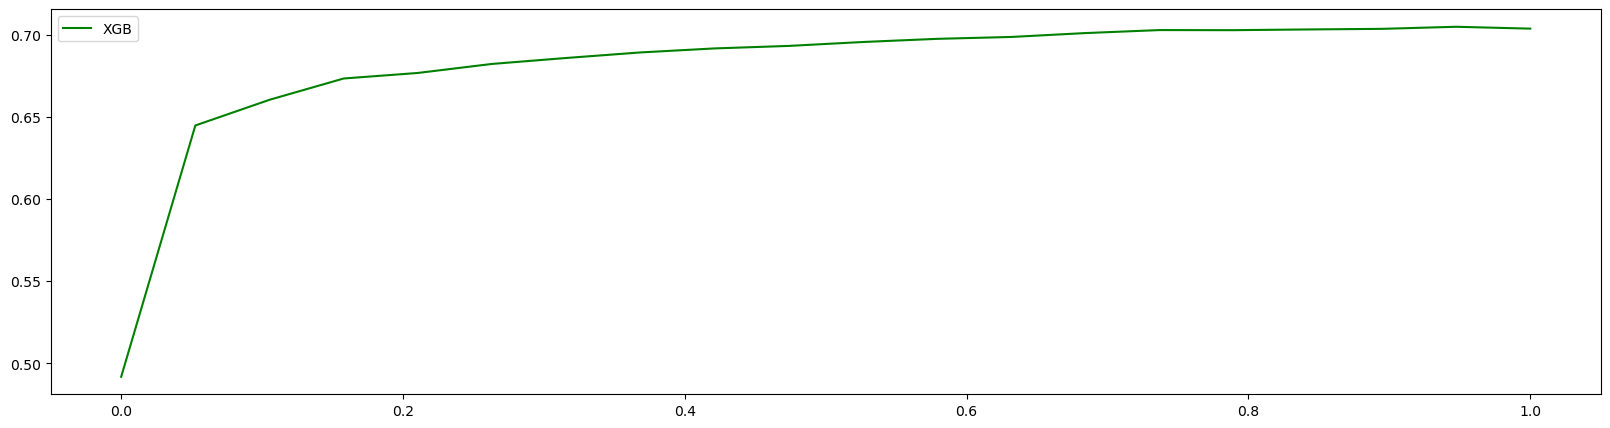

In [36]:
axisx = np.linspace(0,1,20)
rs = []
for i in axisx:
    reg = xgb.XGBClassifier(n_estimators=1000,subsample=i,random_state=420).fit(X_train,Y_train)
    rs.append(reg.score(X_test,Y_test))
    print(i,reg.score(X_test,Y_test))
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()
#细化学习曲线
# axisx = np.linspace(0.05,1,20)
# rs = []
# var = []
# ge = []
# for i in axisx:
#     reg = XGBR(n_estimators=180,subsample=i,random_state=420)
#     cvresult = CVS(reg,Xtrain,Ytrain,cv=cv)
#     rs.append(cvresult.mean())
#     var.append(cvresult.var())
#     ge.append((1 - cvresult.mean())**2+cvresult.var())
# print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
# print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
# print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
# rs = np.array(rs)
# var = np.array(var)
# plt.figure(figsize=(20,5))

c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:42] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
3100 0.7426309178630542


c:\Users\25451\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:39] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


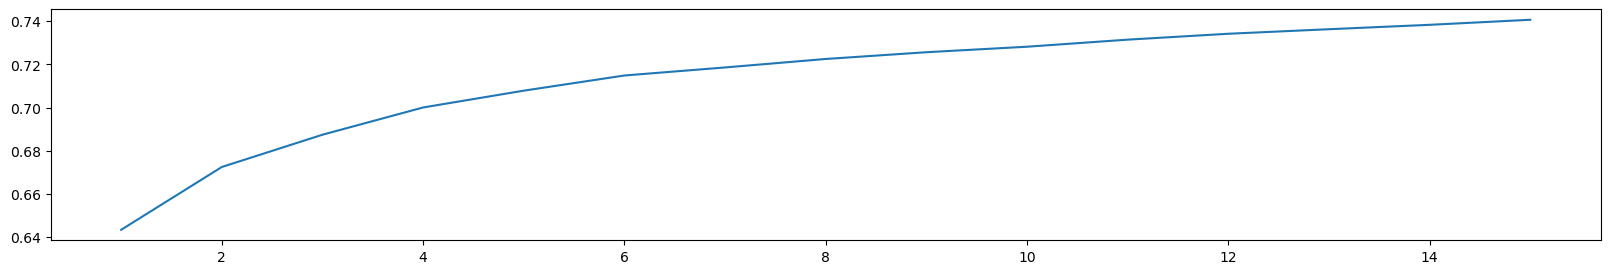

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# 调整评估指标为分类指标（默认为accuracy，可改为F1/roc_auc等）
def CVS(model, X, y, cv=5, scoring='accuracy'):
    return cross_val_score(model, X, y, cv=cv, scoring=scoring)

# 初始学习曲线
axisx = np.linspace(0, 1, 20)
rs = []
for i in axisx:
    clf = XGBClassifier(n_estimators=500, 
                       subsample=i, 
                       random_state=420,
                       use_label_encoder=False,  # 重要！新版本必须添加
                       eval_metric='logloss')     # 消除警告
    scores = CVS(clf, X_train, Y_train, cv=cv)
    rs.append(scores.mean())

print("最佳subsample:", axisx[rs.index(max(rs))], "准确率:", max(rs))

# 可视化
plt.figure(figsize=(20,5))
plt.plot(axisx, rs, c="green", label="XGB Classifier")
plt.xlabel('Subsample Ratio')
plt.ylabel('Validation Accuracy')
plt.title('Subsample Parameter Tuning')
plt.legend()
plt.show()

# 细化分析（添加泛化误差计算）
axisx = np.linspace(0.05, 1, 20)
rs = []
var = []  # 方差
ge = []   # 泛化误差 = (1 - 准确率)^2 + 方差

for i in axisx:
    clf = XGBClassifier(n_estimators=180, 
                       subsample=i, 
                       random_state=420,
                       use_label_encoder=False,
                       eval_metric='logloss')
    cv_result = CVS(clf, X_train, Y_train, cv=cv)
    
    rs.append(cv_result.mean())
    var.append(cv_result.var())
    # 泛化误差公式调整（适用于分类）
    ge.append((1 - cv_result.mean())**2 + cv_result.var())

# 输出关键指标
print("\n最佳准确率: subsample=", axisx[rs.index(max(rs))], 
      "准确率:", max(rs), 
      "方差:", var[rs.index(max(rs))])

print("最小方差: subsample=", axisx[var.index(min(var))],
      "准确率:", rs[var.index(min(var))], 
      "方差:", min(var))

print("最小泛化误差: subsample=", axisx[ge.index(min(ge))],
      "准确率:", rs[ge.index(min(ge))], 
      "方差:", var[ge.index(min(ge))], 
      "GE:", min(ge))

# 可视化对比
plt.figure(figsize=(20,5))
plt.plot(axisx, rs, c="black", label="Accuracy")
plt.plot(axisx, var, c="orange", label="Variance")
plt.plot(axisx, ge, c="red", label="Generalization Error")
plt.legend()
plt.title("Subsample Impact Analysis (Classification)")
plt.xlabel("Subsample Ratio")
plt.ylabel("Metric Value")
plt.show()


KeyboardInterrupt: 

In [ ]:
#验证模型效果是否提高了？
from time import time


time0 = time()
print(xgb.XGBClassifier(n_estimators=1000,random_state=420).fit(X_train,Y_train).score(X_test,Y_test))
print(time()-time0)

c:\Users\25451\anaconda3\envs\machinelearning\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:06:35] WARNING: C:\Users\dev-admin\croot\xgboost-split_1675120659361\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.9653493699885453
1.9347093105316162


In [ ]:
clf.score(X_test,Y_test) #测试
# 对于回归模型(regressor)，score方法返回的是R²决定系数（取值范围负无穷到1），而非准确率。具体取决于模型类型：

# 分类器(Classifier).score() → 返回准确率
# 回归器(Regressor).score() → 返回R²分数

0.5929113575736267

In [ ]:
clf.feature_importances_

array([0.        , 0.01606964, 0.        , 0.02929742, 0.        ,
       0.        , 0.01678955, 0.01149898, 0.01123318, 0.02008874,
       0.0171908 , 0.00931153, 0.01835673, 0.01167384, 0.02589623,
       0.02270683, 0.02025428, 0.01457944, 0.01375134, 0.01203232,
       0.01973157, 0.01508676, 0.01271085, 0.02037509, 0.01631668,
       0.02300294, 0.01183837, 0.02076004, 0.02079588, 0.02465813,
       0.02478091, 0.01585808, 0.00586195, 0.00231853, 0.03689588,
       0.00608053, 0.        , 0.        , 0.        , 0.00591725,
       0.01664179, 0.01549716, 0.0199041 , 0.01242527, 0.01225913,
       0.02424159, 0.00976432, 0.02979082, 0.00888783, 0.        ,
       0.        , 0.        , 0.        , 0.01868097, 0.        ,
       0.        , 0.        , 0.01976294, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01167702, 0.01831177, 0.01900493, 0.12064383, 0.05041

In [ ]:
# cross_val_score(clf,X_train,Y_train,cv=3).mean() #交叉验证

In [ ]:
axisx = np.linspace(0,1,20)
rs = []
for i in axisx:
    reg = xgb.XGBClassifier(n_estimators=180,subsample=i,random_state=420)
    rs.append(CVS(reg,X_train,Y_train,cv=cv).mean())
print(axisx[rs.index(max(rs))],max(rs))
plt.figure(figsize=(20,5))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
plt.plot(axisx,rs,c="green",label="XGB")
plt.legend()
plt.show()
#细化学习曲线
axisx = np.linspace(0.05,1,20)
rs = []
var = []
ge = []
for i in axisx:
    reg = xgb.XGBClassifier(n_estimators=180,subsample=i,random_state=420)
    cvresult = CVS(reg,X_train,Y_train,cv=cv)
    rs.append(cvresult.mean())
    var.append(cvresult.var())
    ge.append((1 - cvresult.mean())**2+cvresult.var())
print(axisx[rs.index(max(rs))],max(rs),var[rs.index(max(rs))])
print(axisx[var.index(min(var))],rs[var.index(min(var))],min(var))
print(axisx[ge.index(min(ge))],rs[ge.index(min(ge))],var[ge.index(min(ge))],min(ge))
rs = np.array(rs)
var = np.array(var)
plt.figure(figsize=(20,5))

<function sklearn.model_selection._validation.cross_val_score(estimator, X, y=None, *, groups=None, scoring=None, cv=None, n_jobs=None, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', error_score=nan)>

In [ ]:
# Cell 8: 类别权重计算

neg_count, pos_count = np.bincount(Y_train)  # y_train已经是整数类型,不需要再转换
scale_pos_weight = neg_count / pos_count
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 0.8605211115505802


In [ ]:
# Cell 9: 模型参数调优

X_train_sample = X_train.sample(frac=0.2, random_state=42)
y_train_sample = Y_train.loc[X_train_sample.index]

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1
)

print("Starting reduced GridSearchCV on subsample...")
try:
    grid_search.fit(X_train_sample, y_train_sample)
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation ROC-AUC:", grid_search.best_score_)
    xgb_model.set_params(**grid_search.best_params_)
except Exception as e:
    print("Error during GridSearchCV:", e)

# 使用最佳参数训练完整模型
print("\n训练完整模型...")
xgb_model.fit(X_train, Y_train)

Starting reduced GridSearchCV on subsample...


KeyboardInterrupt: 

In [ ]:
# Cell 10: 特征重要性分析

# 获取特征重要性分数
feature_importance = xgb_model.feature_importances_

# 创建特征名称和重要性分数的DataFrame
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': feature_importance
})

# 按重要性降序排序
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)

# 绘制特征重要性条形图
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance_df)), feature_importance_df['importance'])
plt.xticks(range(len(feature_importance_df)), feature_importance_df['feature'], rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# 打印前10个最重要的特征
print('\nTop 10 Most Important Features:')
print(feature_importance_df.head(10))

In [ ]:
# Cell 11: 模型评估

try:
    y_pred = xgb_model.predict(X_test)
    y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    print("Classification Report:")
    print(classification_report(Y_test, y_pred))

    roc_auc = roc_auc_score(Y_test, y_pred_proba)
    print("Test ROC-AUC score:", roc_auc)
except Exception as e:
    print("Error during evaluation:", e)

In [ ]:
# Cell 12: 保存训练好的模型

import joblib

# 保存模型
joblib.dump(xgb_model, 'xgboost_model.joblib')

# 保存特征列名(用于后续预测时确保特征顺序一致)
feature_columns = X.columns.tolist()
joblib.dump(feature_columns, 'feature_columns.joblib')

print("模型和特征列名已保存")

In [ ]:

import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_auc_score